In [ ]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt
import gc
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

import plotly.express as px
import TsModel
import GprModel
from sklearn.utils import validation
from windrose import WindroseAxes
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.path import Path
from matplotlib.transforms import Affine2D
from matplotlib.patches import Circle, RegularPolygon

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# Visualization for all models, used in the paper

In [23]:
plt.rcParams.update({'font.size': 16})

In [25]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [27]:
train_x = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9x.csv', index_col=0).to_numpy()
train_y = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9y.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)

test_x = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9x_test.csv', index_col=0).to_numpy()
test_y = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9y_test.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)

input_scaler = StandardScaler()
train_x = input_scaler.fit_transform(train_x)
test_x = input_scaler.transform(test_x)



In [51]:
# Train the TS model
ts_model = TsModel.TsModel(number_of_rules=30, early_end_threshold=1e-8, use_target_in_fcm=False, fuzzification_coefficient=1.2)
ts_model.fit(train_x, train_y)

FCM training RMSE: 5.39307693381169


(29.0852788140117, 5.39307693381169, 546.0016858577728)

In [52]:
test_y_pred = ts_model.predict(test_x)

In [53]:
r2_score(test_y, test_y_pred)

0.6633241331111605

In [35]:
ts_prototypes = ts_model.cen
ts_qs = ts_model.qs
ts_weights = ts_model.W

In [30]:
ts_weights = ts_weights.reshape(30,-1)

In [31]:
ts_prototypes = np.hstack((ts_prototypes, np.zeros((ts_prototypes.shape[0], 1))))

In [36]:
preds = ts_model.predict(ts_prototypes+1e-10)

In [37]:
preds

array([15.98665343, 11.59471142, 12.76121693, 16.03917285, 23.7414936 ,
       26.77454656,  8.90525197,  9.42541042, 14.74922431, 18.05394052,
       20.88485214, 18.76891174, 10.70736027, 23.7385555 ,  8.63859156,
       18.90465452,  3.61384169,  1.96736512, 13.69816117, 13.92158754,
       26.23741202, 11.13263111,  2.09129871, 10.24267897, 27.89714371,
       28.67524929, 16.21572615,  6.47462576, 15.51308991, 20.52583048])

Text(0, 0.5, 'Wind speed')

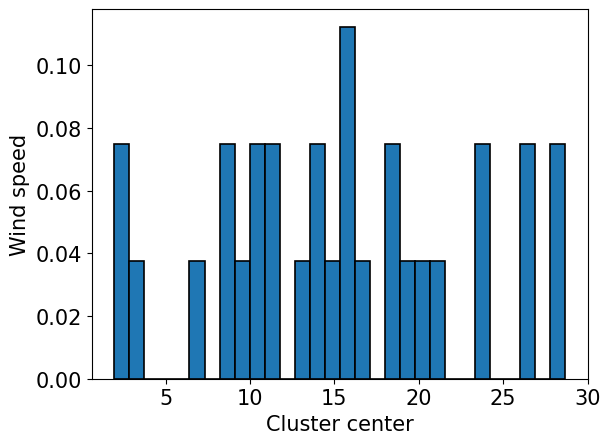

In [46]:
# plt.hist(preds)
# #plt.ylim(14,16)
# plt.ylabel('Predicted values')
# plt.xlabel('Prototypes')

plt.hist(preds,density=True, bins=30,edgecolor='black', linewidth=1.2)
plt.xlabel('Cluster center')
plt.ylabel('Wind speed')

In [12]:
plt.plot([5, 15, 20, 30, 50], results_q)
plt.ylabel('Optimization target')
plt.xlabel('Number of prototypes')

NameError: name 'results_q' is not defined

In [33]:
radar_data=[
    [
        'Long1', 'Lat1', 'Temp1', 'Dir1', 'Speed1', 'Dist1',
        'Long2', 'Lat2', 'Temp2', 'Dir2', 'Speed2', 'Dist2',
        'Long3', 'Lat3', 'Temp3', 'Dir3', 'Speed3', 'Dist3',
        'Long4', 'Lat4', 'Temp4', 'Dir4', 'Speed4', 'Dist4',
        'Long5', 'Lat5', 'Temp5', 'Dir5', 'Speed5', 'Dist5',
        'Long6', 'Lat6', 'Temp6', 'Dir6', 'Speed6', 'Dist6',
        'Long7', 'Lat7', 'Temp7', 'Dir7', 'Speed7', 'Dist7',
        'Long8', 'Lat8', 'Temp8', 'Dir8', 'Speed8', 'Dist8',
        'Long9', 'Lat9', 'Temp9', 'Dir9', 'Speed9', 'Dist9',
        'Bias',
    ],
    ('Prototypes',ts_prototypes),
    ('Conclusion parameters',ts_weights)
]

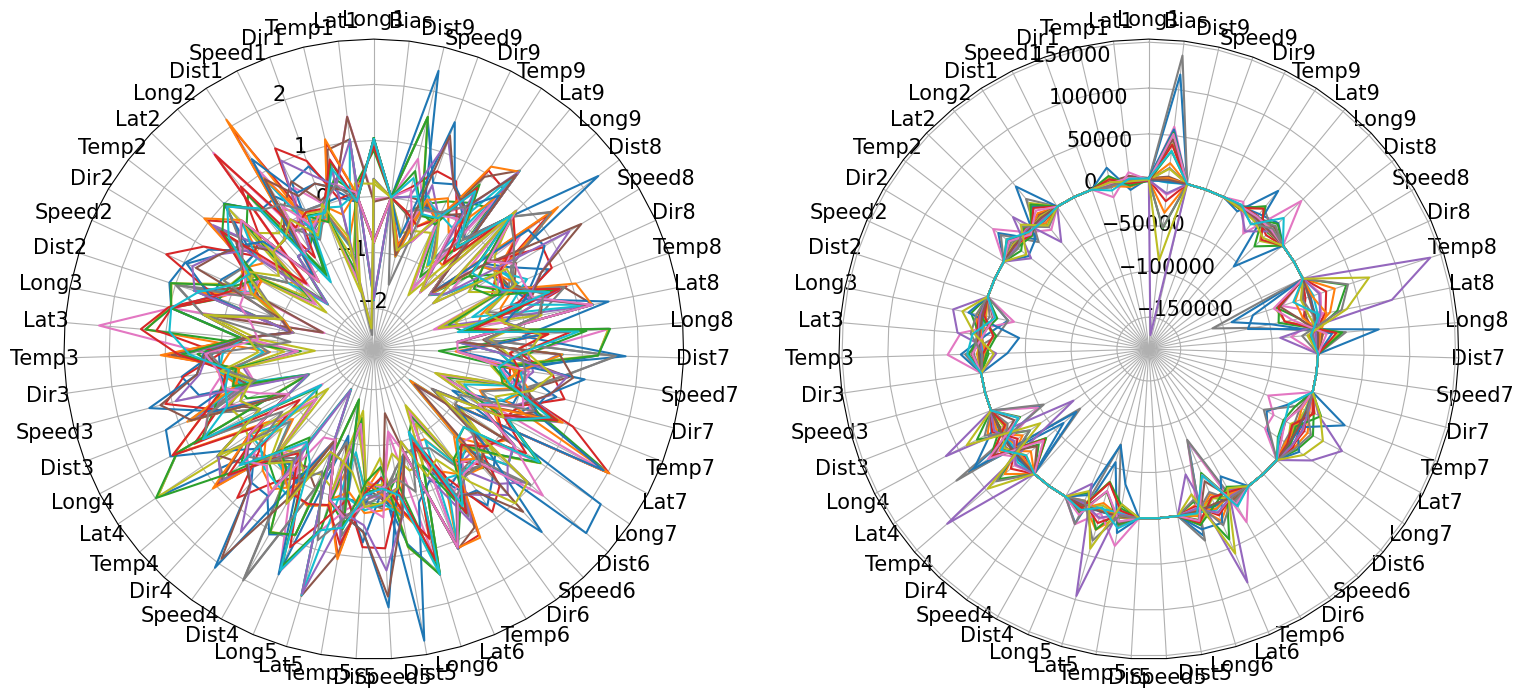

In [34]:
plt.rcParams.update({'font.size': 15})
N = 55
theta = radar_factory(N, frame='polygon')

data = radar_data
spoke_labels = data.pop(0)
#ts_prototypes
fig, axs = plt.subplots(figsize=(18, 9), nrows=1, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
#     ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
#                  horizontalalignment='center', verticalalignment='center')
    for d in case_data:
        ax.plot(theta, d)
        #ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
# labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
# legend = axs.legend(labels, loc=(0.9, .95),
#                           labelspacing=0.1, fontsize='small')

# fig.text(0.5, 0.965, 'Visualization of optimial TS rule-based model c=30',
#          horizontalalignment='center', color='black', weight='bold',
#          size='large')

plt.show()

In [ ]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [ ]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):
    
    ts_model = TsModel.TsModel(number_of_rules=30, early_end_threshold=1e-8, fuzzification_coefficient=1.2)
    _, rmse_train, _ = ts_model.fit(train_x,train_y)
    
    y_hat_validation = ts_model.predict(validation_x)
    rmse_validation = mean_squared_error(validation_y, y_hat_validation,squared=False)

    return rmse_train, rmse_validation

In [ ]:
plt.rcParams.update({'font.size': 18})

In [10]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [8,9, 10,11,12]#[1,2,3,4,5,6,7,8,9, 10,11,12]



# Expeirment related parameters
number_of_folds = 10 # have to be 10 fold

# Results containers
fcm_opt_training_results_cnt = []
fcm_opt_test_results_cnt = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        flatten_train_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # Test data should still need to be generated
        flatten_test_x = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
        flatten_test_y = pd.read_csv(f"Data/exp/1102_no_precp_full_dataset/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)

        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        test_results_fold = []
            
        for i in range(0, number_of_folds):
            flatten_train_x, flatten_train_y = shuffle(flatten_train_x, flatten_train_y)
    
            flatten_train_x = np.asarray(flatten_train_x).astype('float32')
            flatten_train_y = np.asarray(flatten_train_y).astype('float32')
            flatten_test_x = np.asarray(flatten_test_x).astype('float32')
            flatten_test_y = np.asarray(flatten_test_y).astype('float32')
            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")

            # Normalize the input
            norm_flatten_train_x, norm_flatten_test_x = preprocess_data(flatten_train_x, flatten_test_x)            
            
            # FCM model
            fcm_train_rmse, fcm_val_rmse = fcm_rule_model(norm_flatten_train_x, flatten_train_y, norm_flatten_test_x , flatten_test_y)
            training_results_fold.append({'fcm_train' : fcm_train_rmse})
            test_results_fold.append({'fcm_test' : fcm_val_rmse})
        
        #After all folds are done, update the result containers
        fcm_opt_training_results.append(training_results_fold)
        fcm_opt_test_results.append(test_results_fold)        

In [11]:
do_experiment(number_of_neighbour_stations)

Currently running fold 0 for 8 stations
FCM training RMSE: 5.405728650821766
Currently running fold 1 for 8 stations
FCM training RMSE: 5.403069858141655
Currently running fold 2 for 8 stations
FCM training RMSE: 5.403700957134913
Currently running fold 3 for 8 stations
FCM training RMSE: 5.398394541951588
Currently running fold 4 for 8 stations
FCM training RMSE: 5.414750358915544
Currently running fold 5 for 8 stations
FCM training RMSE: 5.406831494809167
Currently running fold 6 for 8 stations
FCM training RMSE: 5.4040075524809605
Currently running fold 7 for 8 stations
FCM training RMSE: 5.40768752727685
Currently running fold 8 for 8 stations
FCM training RMSE: 5.406427152114317
Currently running fold 9 for 8 stations
FCM training RMSE: 5.402929072182682
Currently running fold 0 for 9 stations
FCM training RMSE: 5.393975987525566
Currently running fold 1 for 9 stations
FCM training RMSE: 5.3872403239876885
Currently running fold 2 for 9 stations
FCM training RMSE: 5.40639568392424

In [12]:
fcm_opt_training_results

[[{'fcm_train': 6.406832359164174},
  {'fcm_train': 6.435366989294683},
  {'fcm_train': 6.436489752349981},
  {'fcm_train': 6.412809051816961},
  {'fcm_train': 6.4288975892319575},
  {'fcm_train': 6.417261877188407},
  {'fcm_train': 6.413738863729509},
  {'fcm_train': 6.43682810560236},
  {'fcm_train': 6.426026384156823},
  {'fcm_train': 6.412663170513049}],
 [{'fcm_train': 5.9554607467420935},
  {'fcm_train': 5.936705534859449},
  {'fcm_train': 5.955996033845877},
  {'fcm_train': 5.950019125069372},
  {'fcm_train': 5.971597764942578},
  {'fcm_train': 5.95419324580908},
  {'fcm_train': 5.974585511684725},
  {'fcm_train': 5.94459780198606},
  {'fcm_train': 5.960741084486664},
  {'fcm_train': 5.963247181357915}],
 [{'fcm_train': 5.663319526746949},
  {'fcm_train': 5.658405444098338},
  {'fcm_train': 5.660322888298192},
  {'fcm_train': 5.65811130596754},
  {'fcm_train': 5.658708408068093},
  {'fcm_train': 5.66144103812777},
  {'fcm_train': 5.659203162133961},
  {'fcm_train': 5.67120133044

In [13]:
fcm_opt_test_results

[[{'fcm_test': 6.4165213768721205},
  {'fcm_test': 6.444941990804137},
  {'fcm_test': 6.4460154686491515},
  {'fcm_test': 6.421516388738842},
  {'fcm_test': 6.44406348763912},
  {'fcm_test': 6.430104093022223},
  {'fcm_test': 6.424286192921135},
  {'fcm_test': 6.445089426105813},
  {'fcm_test': 6.442677489385058},
  {'fcm_test': 6.42264360023335}],
 [{'fcm_test': 5.964422040323894},
  {'fcm_test': 5.942499933824255},
  {'fcm_test': 5.958178905622447},
  {'fcm_test': 5.9567788065528},
  {'fcm_test': 5.977477254650819},
  {'fcm_test': 5.961705848523132},
  {'fcm_test': 5.981432240816663},
  {'fcm_test': 5.952746310713949},
  {'fcm_test': 5.969754381060329},
  {'fcm_test': 5.967286792714202}],
 [{'fcm_test': 5.677274868791259},
  {'fcm_test': 5.673634345021601},
  {'fcm_test': 5.674800562200643},
  {'fcm_test': 5.671820652783488},
  {'fcm_test': 5.6700666295318705},
  {'fcm_test': 5.675335241488774},
  {'fcm_test': 5.675388407158652},
  {'fcm_test': 5.6834051245440005},
  {'fcm_test': 5.6

In [15]:
# Deprecated value for m=1.3
# training_results_fcm_mopt = training_results
# test_results_fcm_mopt = test_results

# Current value for m=1.2
# %store fcm_opt_training_results
# %store fcm_opt_test_results

# %store -r training_results
# %store -r test_results

# %store -r training_results_kmeans
# %store -r test_results_kmeans

In [17]:
for exp in fcm_opt_training_results:
    print('exp')
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
 

exp
6.4227±0.0108
exp
5.9567±0.011
exp
5.6616±0.004
exp
5.5659±0.0081
exp
5.5066±0.0104
exp
5.4596±0.0073
exp
5.4547±0.0116
exp
5.4054±0.004
exp
5.3981±0.0069
exp
5.4098±0.0132
exp
5.4319±0.0063
exp
5.3982±0.0064


In [22]:
for exp in fcm_opt_test_results:
    print('exp')
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
 

exp
6.4338±0.0112
exp
5.9632±0.011
exp
5.6758±0.0039
exp
5.5779±0.0082
exp
5.5187±0.0104
exp
5.4819±0.0063
exp
5.4721±0.0097
exp
5.4277±0.0037
exp
5.4216±0.0056
exp
5.4387±0.0116
exp
5.4598±0.0062
exp
5.4267±0.006


Text(0, 0.5, 'RMSE wind speed')

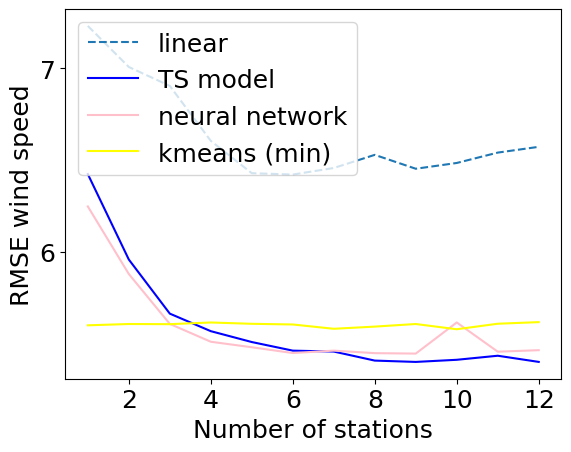

In [19]:
kmeans_train_plot = []
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
kmeans_train_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))
    
for exp in fcm_opt_training_results:
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
        
for exp in training_results_kmeans:
     kmeans_train_plot.append(np.min([d['kmeans_train'] for d in exp if 'kmeans_train' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, kmeans_train_plot, label='kmeans (min)', c='yellow')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

# for exp in training_results_full_feature:
#     print('exp')
#     print(f"{np.round(np.mean([d['kmeans_train'] for d in exp if 'kmeans_train' in d]), 4)}±{np.round(np.std([d['kmeans_train'] for d in exp if 'kmeans_train' in d]),4)}")
 

In [20]:
# gpr_test_results=[]
# gpr_test_results.append({'gpr_test': 124.28245462517742})
# gpr_test_results.append({'gpr_test': 8.098453253845573})
# gpr_test_results.append({'gpr_test': 7.383525517000387})
# gpr_test_results.append({'gpr_test': 7.266723098591452})
# gpr_test_results.append({'gpr_test': 7.269252212307546})
# gpr_test_results.append({'gpr_test': 7.246991937014375})
# gpr_test_results.append({'gpr_test': 7.127975366729728})
# gpr_test_results.append({'gpr_test': 7.125519317911804})
# gpr_test_results.append({'gpr_test': 7.096831995981307})
# gpr_test_results.append({'gpr_test': 7.09245097390881})
# gpr_test_results.append({'gpr_test': 7.123352723065476})
# gpr_test_results.append({'gpr_test': 7.136209476848252})

Text(0, 0.5, 'RMSE wind speed')

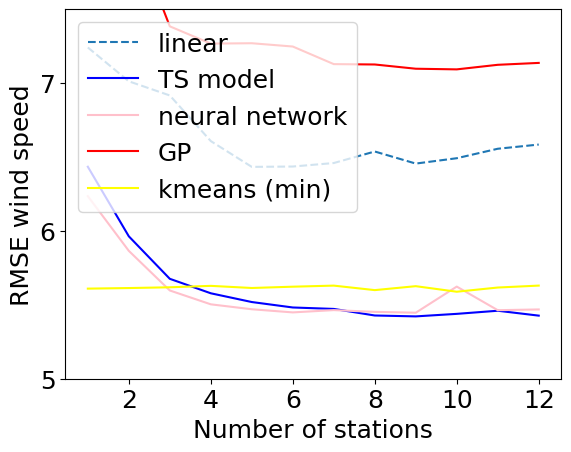

In [21]:
kmeans_train_plot = []
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []
kmeans_train_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10,11,12]
for exp in test_results:
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))
for exp in gpr_test_results[0:12]:
    gpr_test_plot.append(exp['gpr_test'])
    
for exp in fcm_opt_test_results:
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
        
for exp in test_results_kmeans:
     kmeans_train_plot.append(np.min([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.plot(x_axis, gpr_test_plot, label='GP', c='red')
plt.plot(x_axis, kmeans_train_plot, label='kmeans (min)', c='yellow')
plt.legend(loc="upper left")
plt.ylim(5,7.5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
#plt.title('RMSE wind speed vs number of stations on training data')

# for exp in test_results_full_feature:
#     print('exp')
#     print(f"{np.round(np.mean([d['kmeans_test'] for d in exp if 'kmeans_test' in d]), 4)}±{np.round(np.std([d['kmeans_test'] for d in exp if 'kmeans_test' in d]),4)}")
 

In [120]:
kmeans_avg = []
for exp in test_results_full_feature:
    kmeans_avg.append(np.mean([d['kmeans_test'] for d in exp if 'kmeans_test' in d]))

print(f"{np.mean(kmeans_avg)}±{np.round(np.std(kmeans_avg),4)}")
 

35333916409.24774±69136985570.5394
